# Определение стоимости автомобилей

Условный сервис по продаже автомобилей разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


STATE = 12345

Создадим датафрейм для внесения результатов:
- `model_name` - наименование модели
- `rmse_model` - качество предсказания;
- `time_predict` - скорость предсказания в милисекундах;
- `time_fit` - время обучения  в милисекундах.

In [3]:
column_names = ['model_name', 'time_fit', 'time_predict', 'rmse_model']
df_results = pd.DataFrame(columns = column_names)
display(df_results)

,model_name,time_fit,time_predict,rmse_model


In [4]:
def update_results(model_name, time_fit, time_predict, rmse_model, df_results):
    """функция обновления датафрейма с результатами"""
    resultRowStr= [model_name, time_fit, time_predict, rmse_model]
    rows = [pd.Series(resultRowStr, index=df_results.columns)]
    df_results=df_results.append(rows,ignore_index=True)
    return(df_results)

## Подготовка данных

In [5]:
def review(df): 
    """функция для отображения общей информации"""
    info = display(df.head(10)), df.info(), display(df.describe()) 
    if df.duplicated().sum() == 0:
        print('Дубликатов не обнаружено')
    else:
        print('Дубликатов найдено: {}'.format(df.duplicated().sum()))

In [6]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [7]:
review(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Дубликатов найдено: 4


In [8]:
(df.isna().mean() * 100).round(2)

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
NotRepaired          20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

### Вывод

- в данных обнаружены дубликаты;
- пропущенные значения в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`.;
- неверный тип данных в столбцах `DateCrawled`, `DateCreated`, `LastSeen`.

## Предобработка

Избавимся от дубликатов

In [9]:
df = df.drop_duplicates().reset_index(drop = True)

Проверим неявные дубликаты в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `NotRepaired`.

In [10]:
df_unique = df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]
for column in df_unique.columns:
    print(df[column].unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto' nan]
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3

Пропущенные значения в категорийный столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` заменим модой.

In [11]:
df['VehicleType'] = df['VehicleType'].fillna(df['VehicleType'].mode().values[0])
df['Gearbox'] = df['Gearbox'].fillna(df['Gearbox'].mode().values[0])
df['Model'] = df['Model'].fillna(df['Model'].mode().values[0])
df['FuelType'] = df['FuelType'].fillna(df['FuelType'].mode().values[0])

Пропущенные значения в столбце `NotRepaired` заменим на `no`

In [131]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

Приведем значения `DateCrawled`, `DateCreated`, `LastSeen` к типу данных `datetime`.

In [13]:
columns_to_datetime = {'DateCrawled':df,
                       'DateCreated':df,
                       'LastSeen':df
                      }

for column, frame in columns_to_datetime.items():
    frame[column] = pd.to_datetime(frame[column],format = '%Y-%m-%d %H:%M:%S')

In [14]:
df = df.drop_duplicates().reset_index(drop = True)

In [15]:
review(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,no,2016-03-17,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354364 entries, 0 to 354363
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354364 non-null  datetime64[ns]
 1   Price              354364 non-null  int64         
 2   VehicleType        354364 non-null  object        
 3   RegistrationYear   354364 non-null  int64         
 4   Gearbox            354364 non-null  object        
 5   Power              354364 non-null  int64         
 6   Model              354364 non-null  object        
 7   Kilometer          354364 non-null  int64         
 8   RegistrationMonth  354364 non-null  int64         
 9   FuelType           354364 non-null  object        
 10  Brand              354364 non-null  object        
 11  NotRepaired        354364 non-null  object        
 12  DateCreated        354364 non-null  datetime64[ns]
 13  NumberOfPictures   354364 non-null  int64   

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000,354364.0,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641,0.0,50508.461698
std,4514.159690,90.228593,189.851590,37905.136957,3.726433,0.0,25783.124276
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49409.500000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Дубликатов не обнаружено


На основе датафрейма `df` создадим датафрейм `filtered_df` для дальнейшего исследования.

In [16]:
filtered_df = df.drop(['DateCrawled', 
                       'DateCreated', 
                       'LastSeen', 
                       'NumberOfPictures', 
                       'PostalCode'], axis = 1).reset_index(drop = True)

Посмотрим на распределения данных и избавимся от выбросов

In [17]:
def show_hist(df):
    """функция для построения гистограммы"""
    plt.figure(figsize=(15,5))
    ax = sns.distplot(df, bins=100)

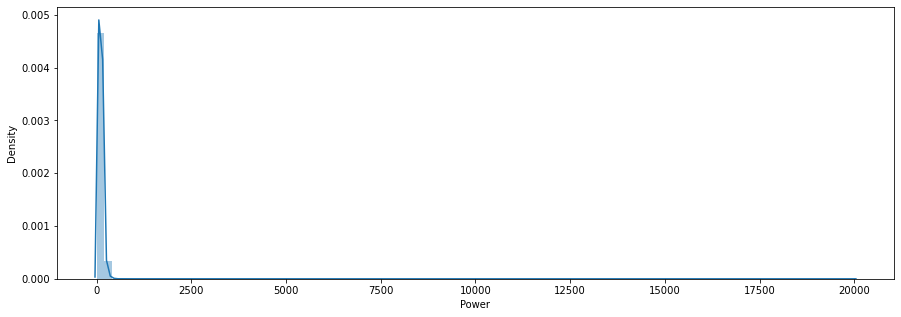

In [18]:
show_hist(filtered_df['Power'])

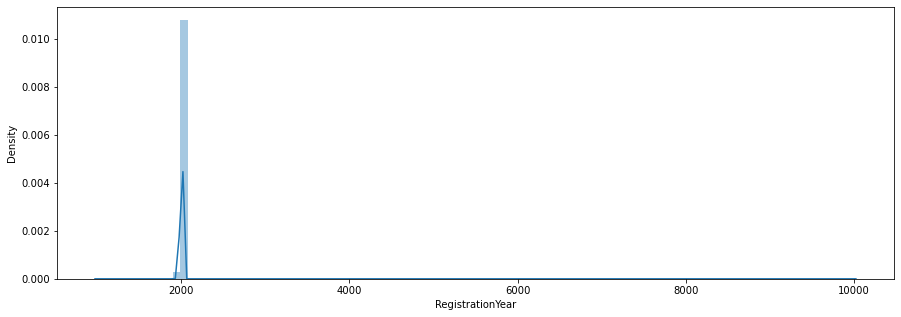

In [19]:
show_hist(filtered_df['RegistrationYear'])

В данные столбца `Power` наблюдаются аномальные значения (0 и 20 000 лошадиных сил), ограничим их мощность - отбросим данные менее `20` и превышающие [2000](https://atlanticexpress.com.ua/samye-moshhnye-serijnye-avto-v-mire-ot-1750-l-s/#:~:text=1.-,Lotus%20Evija,-%D0%9C%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C%3A%202000%20%D0%BB).

In [20]:
filtered_df = filtered_df.query('20 < Power < 2000')

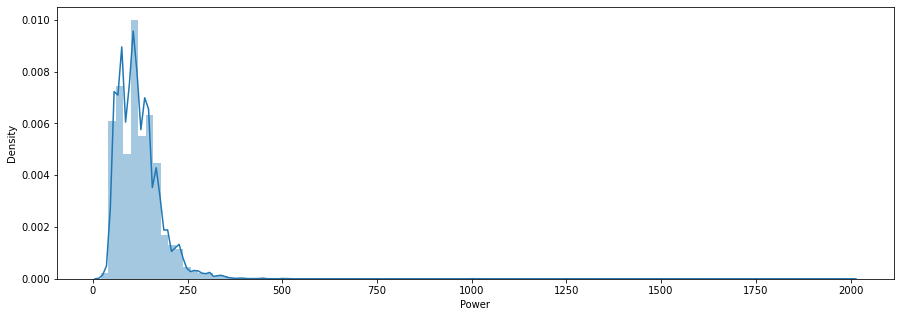

In [21]:
show_hist(filtered_df['Power'])

В данных столбца `RegistrationYear` также наблюдаются аномальные значения (1000 и 9999 год выпуска) - отбросим данные до 1900 года и превышающие дату последнего скачивания анкеты из базы

In [22]:
df['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [23]:
filtered_df = filtered_df.query('1900 < RegistrationYear < 2017')

Посмотрим на распределение данных

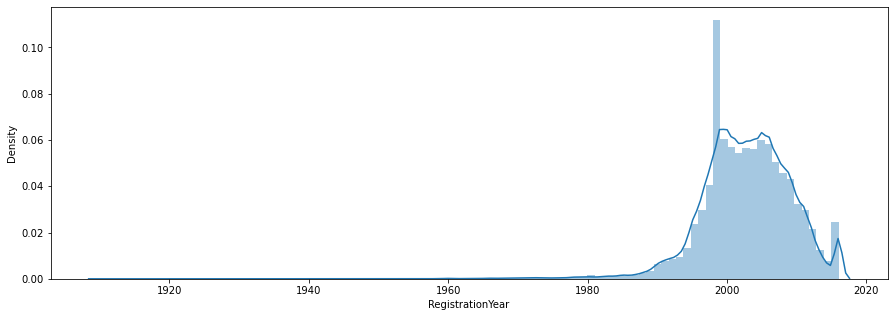

In [24]:
show_hist(filtered_df['RegistrationYear'])

Также отбросим данные до 1960 года

In [25]:
filtered_df = filtered_df.query('1960 < RegistrationYear')

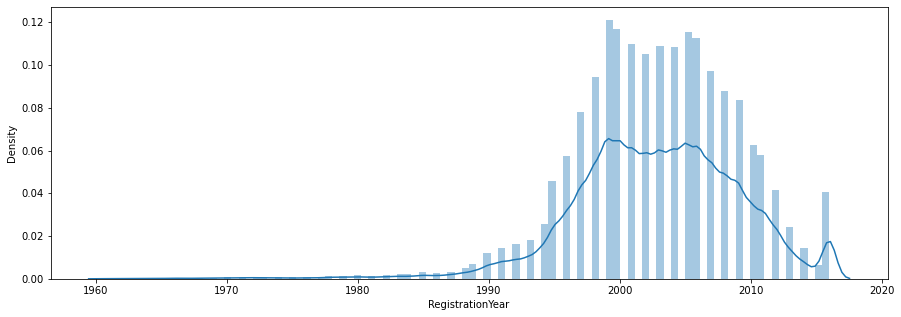

In [26]:
show_hist(filtered_df['RegistrationYear'])

В данные столбца `RegistrationMonth` также наблюдаются аномальные значения (0 месяц) - проверим по какой логике идет заполнение данных

In [27]:
filtered_df['RegistrationMonth'].value_counts()

3     30818
6     28075
4     26171
5     26081
7     24234
10    23341
12    21616
11    21381
9     21303
1     20539
8     20109
0     19717
2     19196
Name: RegistrationMonth, dtype: int64

Вероятно запись месяцев ведется от `1` до `12`, т.е. `1` - январь, `2` - февраль и т.д. Отбросим значения равные `0`.

In [28]:
filtered_df = filtered_df.query('0 < RegistrationMonth < 13')

In [29]:
filtered_df['RegistrationMonth'].value_counts()

3     30818
6     28075
4     26171
5     26081
7     24234
10    23341
12    21616
11    21381
9     21303
1     20539
8     20109
2     19196
Name: RegistrationMonth, dtype: int64

In [30]:
filtered_df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

In [31]:
def remove_ouliers(df, column):
    q25=np.array(df[column].quantile(0.25))
    
    q75=np.array(df[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(df[column].index, df[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    return del_index

In [32]:
array_num_col = ['Price']
count = 0 
for column in array_num_col:
    index_del = remove_ouliers(filtered_df, column)
    count += len(index_del)
    filtered_df = filtered_df.drop(index_del,axis = 0)
print("Было удалено:", count)

Было удалено: 12360


In [33]:
filtered_df.reset_index(drop=True, inplace=True)

In [34]:
filtered_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,270504.000000,270504.000000,270504.000000,270504.000000,270504.000000
mean,4344.139310,2002.693369,119.274913,129720.318369,6.381384
std,3840.510057,6.166625,61.054449,35337.470987,3.348278
min,0.000000,1961.000000,21.000000,5000.000000,1.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,4.000000
50%,3000.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6500.000000,2007.000000,145.000000,150000.000000,9.000000
max,15700.000000,2016.000000,1998.000000,150000.000000,12.000000


Проверим корреляцию данных

In [35]:
filtered_df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.501205,0.384809,-0.345101,0.015551
RegistrationYear,0.501205,1.000000,0.085328,-0.289867,0.005250
Power,0.384809,0.085328,1.000000,0.121521,0.019653
Kilometer,-0.345101,-0.289867,0.121521,1.000000,0.004505
RegistrationMonth,0.015551,0.005250,0.019653,0.004505,1.000000


Каких либо аномалий нет - наиболее коррелирующим с целевим признаком является признак `RegistrationYear`.

### Вывод

- из данных были удалены дубликаты;
- пропущенные значения в категорийный столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` были заменены модой;
- пропущенные значения в столбце `NotRepaired` были заменены на `no`;
- на основе датафрейма `df` создан датафрейм `filtered_df` для дальнейшего исследования, где были очищены выбросы и аномальные значения.


## Обучение моделей

### Разделим и закодируем выборки

Исследование будем проводить на двух выборках:
- `filtered_df_ohe` - с преобразованными категориальными признаками;
- `filtered_df_encoder` - с закодированными данными с помошью Ordinal Encoder.

In [36]:
filtered_df_ohe = filtered_df.copy()
filtered_df_ohe = pd.get_dummies(filtered_df_ohe)

In [37]:
listCategory = ['VehicleType', 
                'RegistrationYear', 
                'Gearbox', 
                'Model', 
                'RegistrationMonth', 
                'FuelType', 
                'Brand', 
                'NotRepaired']
encoder = OrdinalEncoder()
filtered_df_encoder = filtered_df.copy()
filtered_df_encoder[listCategory] = encoder.fit_transform(filtered_df_encoder[listCategory])

In [38]:
def split_data(features, target):
    """функция для формирования обучающей, тестовой выборок"""
    (features_train, features_test, target_train, target_test) = train_test_split(features, target, test_size = 0.25, random_state=STATE)
    return (features_train, features_test, target_train, target_test)

In [39]:
(x_train_filtered_df_ohe, 
 x_test_filtered_df_ohe, 
 y_train_filtered_df_ohe,
 y_test_filtered_df_ohe) = split_data(filtered_df_ohe.drop('Price', axis = 1), 
                                           filtered_df_ohe['Price'])

In [40]:
print(x_train_filtered_df_ohe.shape)
print(y_train_filtered_df_ohe.shape)
print(x_test_filtered_df_ohe.shape)
print(y_test_filtered_df_ohe.shape)

(202878, 312)
(202878,)
(67626, 312)
(67626,)


In [41]:
(x_train_filtered_df_encoder, 
 x_test_filtered_df_encoder, 
 y_train_filtered_df_encoder,
 y_test_filtered_df_encoder) = split_data(filtered_df_encoder.drop('Price', axis = 1), 
                                        filtered_df_encoder['Price'])

In [42]:
print(x_train_filtered_df_encoder.shape)
print(y_train_filtered_df_encoder.shape)
print(x_test_filtered_df_encoder.shape)
print(y_test_filtered_df_encoder.shape)

(202878, 10)
(202878,)
(67626, 10)
(67626,)


### Обучение моделей

In [43]:
def rmse_scorer(target: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mean_squared_error(target, 
                                      predicted))
rmse_scoring = make_scorer(rmse_scorer,
                           greater_is_better=False)

In [44]:
def fit_models(model, features_train, target_train, features_test, target_test):
    """функция обучения и предсказания моделей с регистрацией затраченного времени"""
    start_fit = time.time()
    model.fit(features_train, target_train)
    time_fit = time.time() - start_fit

    start_predict = time.time()
    predicted_test = model.predict(features_test)
    time_predict = time.time() - start_predict

    rmse_model = rmse_scorer(target_test, predicted_test) 

    return(rmse_model,
           time_fit * 1000,
           time_predict * 1000)

#### LinearRegression

In [45]:
model_lr = LinearRegression()

In [46]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_lr,
                            x_train_filtered_df_ohe, 
                            y_train_filtered_df_ohe,
                            x_test_filtered_df_ohe, 
                            y_test_filtered_df_ohe)

In [47]:
model_name = 'LinearRegression for filtered_df_ohe'

In [48]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584


In [49]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_lr,
                            x_train_filtered_df_encoder,
                            y_train_filtered_df_encoder, 
                            x_test_filtered_df_encoder, 
                            y_test_filtered_df_encoder)

In [50]:
model_name = 'LinearRegression for filtered_df_encoder'

In [51]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584
1,LinearRegression for filtered_df_encoder,93.75,5.98526,2696.782272


#### RandomForestRegressor

In [52]:
model_rfr = RandomForestRegressor()

In [53]:
parametrs_rfr = {'n_estimators':[10,30,50], 
                 'max_depth':[1,5,10],
                'random_state':[STATE]} 

In [54]:
grid_rfr = GridSearchCV(estimator=model_rfr, 
                        param_grid=parametrs_rfr, 
                        scoring=rmse_scoring, 
                        cv=3)

In [55]:
grid_rfr.fit(x_train_filtered_df_ohe, y_train_filtered_df_ohe)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 5, 10], 'n_estimators': [10, 30, 50],
                         'random_state': [12345]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False))

In [60]:
print('Лучшие параметры модели RandomForestRegressor для filtered_df_ohe - {}'.format(grid_rfr.best_params_))

Лучшие параметры модели RandomForestRegressor для filtered_df_ohe - {'max_depth': 10, 'n_estimators': 50, 'random_state': 12345}


In [63]:
model_rfr = RandomForestRegressor(max_depth=10, 
                                  n_estimators=50, 
                                  random_state=STATE)

In [64]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_rfr,
                            x_train_filtered_df_ohe, 
                            y_train_filtered_df_ohe,
                            x_test_filtered_df_ohe, 
                            y_test_filtered_df_ohe)

In [65]:
model_name = 'RandomForestRegressor for filtered_df_ohe'

In [66]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584
1,LinearRegression for filtered_df_encoder,93.75,5.98526,2696.782272
2,RandomForestRegressor for filtered_df_ohe,154792.466164,496.670723,1713.614552


In [67]:
grid_rfr.fit(x_train_filtered_df_encoder, y_train_filtered_df_encoder)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 5, 10], 'n_estimators': [10, 30, 50],
                         'random_state': [12345]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False))

In [68]:
print('Лучшие параметры модели RandomForestRegressor для filtered_df_encoder- {}'.format(grid_rfr.best_params_))

Лучшие параметры модели RandomForestRegressor для filtered_df_encoder- {'max_depth': 10, 'n_estimators': 50, 'random_state': 12345}


In [69]:
model_rfr = RandomForestRegressor(max_depth=10, 
                                  n_estimators=50, 
                                  random_state=STATE)

In [70]:
(rmse_model,
 time_fit,
 time_predict) = fit_models(model_rfr,
                            x_train_filtered_df_encoder,
                            y_train_filtered_df_encoder, 
                            x_test_filtered_df_encoder, 
                            y_test_filtered_df_encoder)

In [71]:
model_name = 'RandomForestRegressor for filtered_df_encoder'

In [72]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584
1,LinearRegression for filtered_df_encoder,93.75,5.98526,2696.782272
2,RandomForestRegressor for filtered_df_ohe,154792.466164,496.670723,1713.614552
3,RandomForestRegressor for filtered_df_encoder,21973.091364,384.974241,1709.050554


#### CatBoostRegressor

In [73]:
model_cbr = CatBoostRegressor()

In [74]:
parameters_cbr = {'depth':[6,8,10],
                  'learning_rate':[0.1,0.5],
                  'metric_period':[10],
                  'random_state':[STATE]} 

In [75]:
grid_cbr = GridSearchCV(estimator=model_cbr, 
                        param_grid=parameters_cbr, 
                        scoring=rmse_scoring, 
                        cv=3, 
                        n_jobs=-1, 
                        verbose=1)

In [76]:
grid_cbr.fit(x_train_filtered_df_ohe, y_train_filtered_df_ohe)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0:	learn: 3578.0108270	total: 224ms	remaining: 3m 43s
10:	learn: 2208.6095118	total: 870ms	remaining: 1m 18s
20:	learn: 1832.1251174	total: 1.6s	remaining: 1m 14s
30:	learn: 1710.0481719	total: 2.24s	remaining: 1m 10s
40:	learn: 1654.2210008	total: 3.08s	remaining: 1m 12s
50:	learn: 1624.5169621	total: 3.72s	remaining: 1m 9s
60:	learn: 1602.2761722	total: 4.35s	remaining: 1m 6s
70:	learn: 1585.3603956	total: 5s	remaining: 1m 5s
80:	learn: 1570.7029167	total: 5.65s	remaining: 1m 4s
90:	learn: 1558.4072838	total: 6.29s	remaining: 1m 2s
100:	learn: 1548.1907078	total: 6.91s	remaining: 1m 1s
110:	learn: 1538.3605334	total: 7.67s	remaining: 1m 1s
120:	learn: 1529.4901446	total: 8.3s	remaining: 1m
130:	learn: 1519.9840912	total: 9.03s	remaining: 59.9s
140:	learn: 1511.9329031	total: 9.66s	remaining: 58.9s
150:	learn: 1504.5235749	total: 10.3s	remaining: 57.9s
160:	learn: 1497.9596987	total: 10.9s	remaining: 57.1s
170:	learn: 1490.81

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001CF0F419C10>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'learning_rate': [0.1, 0.5],
                         'metric_period': [10], 'random_state': [12345]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False),
             verbose=1)

In [77]:
print('Лучшие параметры модели CatBoostRegressor для filtered_df_ohe - {}'.format(grid_cbr.best_params_))

Лучшие параметры модели CatBoostRegressor для filtered_df_ohe - {'depth': 10, 'learning_rate': 0.1, 'metric_period': 10, 'random_state': 12345}


In [78]:
model_cbr = CatBoostRegressor(depth=10,
                              learning_rate=0.1,
                              metric_period=10,
                              random_state=STATE) 

In [79]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_cbr,
                            x_train_filtered_df_ohe,
                            y_train_filtered_df_ohe, 
                            x_test_filtered_df_ohe, 
                            y_test_filtered_df_ohe)

0:	learn: 3578.0108270	total: 117ms	remaining: 1m 56s
10:	learn: 2208.6095118	total: 886ms	remaining: 1m 19s
20:	learn: 1832.1251174	total: 1.6s	remaining: 1m 14s
30:	learn: 1710.0481719	total: 2.24s	remaining: 1m 10s
40:	learn: 1654.2210008	total: 2.9s	remaining: 1m 7s
50:	learn: 1624.5169621	total: 3.55s	remaining: 1m 5s
60:	learn: 1602.2761722	total: 4.17s	remaining: 1m 4s
70:	learn: 1585.3603956	total: 4.95s	remaining: 1m 4s
80:	learn: 1570.7029167	total: 5.72s	remaining: 1m 4s
90:	learn: 1558.4072838	total: 6.47s	remaining: 1m 4s
100:	learn: 1548.1907078	total: 7.14s	remaining: 1m 3s
110:	learn: 1538.3605334	total: 7.78s	remaining: 1m 2s
120:	learn: 1529.4901446	total: 8.41s	remaining: 1m 1s
130:	learn: 1519.9840912	total: 9.07s	remaining: 1m
140:	learn: 1511.9329031	total: 9.7s	remaining: 59.1s
150:	learn: 1504.5235749	total: 10.4s	remaining: 58.3s
160:	learn: 1497.9596987	total: 11s	remaining: 57.2s
170:	learn: 1490.8169641	total: 11.6s	remaining: 56.2s
180:	learn: 1485.9158953	

In [80]:
model_name = 'CatBoostRegressor for filtered_df_ohe'

In [81]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584
1,LinearRegression for filtered_df_encoder,93.75,5.98526,2696.782272
2,RandomForestRegressor for filtered_df_ohe,154792.466164,496.670723,1713.614552
3,RandomForestRegressor for filtered_df_encoder,21973.091364,384.974241,1709.050554
4,CatBoostRegressor for filtered_df_ohe,70294.345617,581.445217,1434.457971


In [82]:
grid_cbr.fit(x_train_filtered_df_encoder, y_train_filtered_df_encoder)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0:	learn: 3579.2974581	total: 76.1ms	remaining: 1m 16s
10:	learn: 2211.2298925	total: 944ms	remaining: 1m 24s
20:	learn: 1835.5706114	total: 1.73s	remaining: 1m 20s
30:	learn: 1705.2664476	total: 2.46s	remaining: 1m 16s
40:	learn: 1650.4631473	total: 3.13s	remaining: 1m 13s
50:	learn: 1617.2137647	total: 3.76s	remaining: 1m 9s
60:	learn: 1587.0467286	total: 4.33s	remaining: 1m 6s
70:	learn: 1567.2119002	total: 4.92s	remaining: 1m 4s
80:	learn: 1553.6877848	total: 5.56s	remaining: 1m 3s
90:	learn: 1540.6724643	total: 6.13s	remaining: 1m 1s
100:	learn: 1529.0474542	total: 6.71s	remaining: 59.7s
110:	learn: 1517.3211661	total: 7.3s	remaining: 58.5s
120:	learn: 1506.7580306	total: 7.92s	remaining: 57.5s
130:	learn: 1496.9331339	total: 8.64s	remaining: 57.3s
140:	learn: 1487.4100622	total: 9.34s	remaining: 56.9s
150:	learn: 1479.6609850	total: 10s	remaining: 56.3s
160:	learn: 1472.3731694	total: 10.7s	remaining: 55.6s
170:	learn: 1

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001CF0F419C10>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'learning_rate': [0.1, 0.5],
                         'metric_period': [10], 'random_state': [12345]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False),
             verbose=1)

In [83]:
print('Лучшие параметры модели CatBoostRegressor для filtered_df_encoder - {}'.format(grid_cbr.best_params_))

Лучшие параметры модели CatBoostRegressor для filtered_df_encoder - {'depth': 10, 'learning_rate': 0.1, 'metric_period': 10, 'random_state': 12345}


In [84]:
model_cbr = CatBoostRegressor(depth=10,
                              learning_rate=0.1,
                              metric_period=10,
                              random_state=STATE) 

In [85]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_cbr,
                            x_train_filtered_df_encoder,
                            y_train_filtered_df_encoder, 
                            x_test_filtered_df_encoder, 
                            y_test_filtered_df_encoder)

0:	learn: 3579.2974581	total: 62.4ms	remaining: 1m 2s
10:	learn: 2211.2298925	total: 599ms	remaining: 53.9s
20:	learn: 1835.5706114	total: 1.38s	remaining: 1m 4s
30:	learn: 1705.2664476	total: 2.04s	remaining: 1m 3s
40:	learn: 1650.4631473	total: 2.65s	remaining: 1m 2s
50:	learn: 1617.2137647	total: 3.4s	remaining: 1m 3s
60:	learn: 1587.0467286	total: 4.08s	remaining: 1m 2s
70:	learn: 1567.2119002	total: 4.77s	remaining: 1m 2s
80:	learn: 1553.6877848	total: 5.44s	remaining: 1m 1s
90:	learn: 1540.6724643	total: 6.13s	remaining: 1m 1s
100:	learn: 1529.0474542	total: 6.77s	remaining: 1m
110:	learn: 1517.3211661	total: 7.35s	remaining: 58.9s
120:	learn: 1506.7580306	total: 7.92s	remaining: 57.5s
130:	learn: 1496.9331339	total: 8.57s	remaining: 56.9s
140:	learn: 1487.4100622	total: 9.14s	remaining: 55.7s
150:	learn: 1479.6609850	total: 9.7s	remaining: 54.5s
160:	learn: 1472.3731694	total: 10.3s	remaining: 53.5s
170:	learn: 1466.1319318	total: 10.8s	remaining: 52.5s
180:	learn: 1459.4596425	

In [86]:
model_name = 'CatBoostRegressor for filtered_df_encoder'

In [87]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584
1,LinearRegression for filtered_df_encoder,93.75,5.98526,2696.782272
2,RandomForestRegressor for filtered_df_ohe,154792.466164,496.670723,1713.614552
3,RandomForestRegressor for filtered_df_encoder,21973.091364,384.974241,1709.050554
4,CatBoostRegressor for filtered_df_ohe,70294.345617,581.445217,1434.457971
5,CatBoostRegressor for filtered_df_encoder,69232.55682,554.518223,1433.374578


#### LGBMRegressor

In [88]:
model_lgbmr = LGBMRegressor()

In [89]:
parameters_lgbmr = {'num_leaves':[60],
                    'learning_rate':[0.1,0.5],
                    'max_depth':[6,10],
                    'random_state':[STATE]}

In [90]:
grid_lgbmr = GridSearchCV(estimator=model_lgbmr, 
                          param_grid=parameters_lgbmr, 
                          scoring=rmse_scoring, 
                          cv=3, 
                          n_jobs=-1)

In [91]:
grid_lgbmr.fit(x_train_filtered_df_ohe, y_train_filtered_df_ohe)

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [6, 10],
                         'num_leaves': [60], 'random_state': [12345]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False))

In [92]:
print('Лучшие параметры модели LGBMRegressor для filtered_df_ohe - {}'.format(grid_lgbmr.best_params_))

Лучшие параметры модели LGBMRegressor для filtered_df_ohe - {'learning_rate': 0.5, 'max_depth': 10, 'num_leaves': 60, 'random_state': 12345}


In [93]:
model_lgbmr = LGBMRegressor(learning_rate=0.5,
                            max_depth=10,
                            num_leaves=60,
                            random_state=STATE)

In [94]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_lgbmr,
                            x_train_filtered_df_ohe,
                            y_train_filtered_df_ohe, 
                            x_test_filtered_df_ohe, 
                            y_test_filtered_df_ohe)

In [95]:
model_name = 'LGBMRegressor for filtered_df_ohe'

In [96]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584
1,LinearRegression for filtered_df_encoder,93.75,5.98526,2696.782272
2,RandomForestRegressor for filtered_df_ohe,154792.466164,496.670723,1713.614552
3,RandomForestRegressor for filtered_df_encoder,21973.091364,384.974241,1709.050554
4,CatBoostRegressor for filtered_df_ohe,70294.345617,581.445217,1434.457971
5,CatBoostRegressor for filtered_df_encoder,69232.55682,554.518223,1433.374578
6,LGBMRegressor for filtered_df_ohe,3091.12525,788.086653,1480.693069


In [97]:
grid_lgbmr.fit(x_train_filtered_df_encoder, y_train_filtered_df_encoder)

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [6, 10],
                         'num_leaves': [60], 'random_state': [12345]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False))

In [98]:
print('Лучшие параметры модели LGBMRegressor для filtered_df_encoder - {}'.format(grid_lgbmr.best_params_))

Лучшие параметры модели LGBMRegressor для filtered_df_encoder - {'learning_rate': 0.5, 'max_depth': 10, 'num_leaves': 60, 'random_state': 12345}


In [99]:
model_lgbmr = LGBMRegressor(learning_rate=0.5,
                            max_depth=10,
                            num_leaves=60,
                            random_state=STATE)

In [100]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_lgbmr,
                            x_train_filtered_df_encoder,
                            y_train_filtered_df_encoder, 
                            x_test_filtered_df_encoder, 
                            y_test_filtered_df_encoder)

In [101]:
model_name = 'LGBMRegressor for filtered_df_encoder'

In [102]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584
1,LinearRegression for filtered_df_encoder,93.75,5.98526,2696.782272
2,RandomForestRegressor for filtered_df_ohe,154792.466164,496.670723,1713.614552
3,RandomForestRegressor for filtered_df_encoder,21973.091364,384.974241,1709.050554
4,CatBoostRegressor for filtered_df_ohe,70294.345617,581.445217,1434.457971
5,CatBoostRegressor for filtered_df_encoder,69232.55682,554.518223,1433.374578
6,LGBMRegressor for filtered_df_ohe,3091.12525,788.086653,1480.693069
7,LGBMRegressor for filtered_df_encoder,1094.083548,238.352299,1491.956922


#### XGBRegressor

In [103]:
model_xgbr = XGBRegressor()

In [108]:
parameters_xgbr = {'learning_rate':[0.1,0.5],
                   'max_depth':[6,12],
                   'subsample':[0.5],
                   'colsample_bytree':[0.5],
                   'random_state':[STATE]}

In [109]:
grid_xgbr = GridSearchCV(estimator=model_xgbr,
                         param_grid=parameters_xgbr,
                         scoring=rmse_scoring,
                         cv=3,
                         n_jobs=-1,
                         verbose=1)

In [110]:
grid_xgbr.fit(x_train_filtered_df_ohe, y_train_filtered_df_ohe)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [111]:
print('Лучшие параметры модели XGBRegressor для filtered_df_ohe - {}'.format(grid_xgbr.best_params_))

Лучшие параметры модели XGBRegressor для filtered_df_ohe - {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 12, 'random_state': 12345, 'subsample': 0.5}


In [114]:
model_xgbr = XGBRegressor(colsample_bytre=0.5,
                          learning_rate=0.1,
                          max_depth=12,
                          random_state=STATE,
                          subsample=0.5)

In [116]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_xgbr,
                            x_train_filtered_df_ohe,
                            y_train_filtered_df_ohe, 
                            x_test_filtered_df_ohe, 
                            y_test_filtered_df_ohe)

[09:59:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytre" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [117]:
model_name = 'XGBRegressor for filtered_df_ohe'

In [118]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584
1,LinearRegression for filtered_df_encoder,93.75,5.98526,2696.782272
2,RandomForestRegressor for filtered_df_ohe,154792.466164,496.670723,1713.614552
3,RandomForestRegressor for filtered_df_encoder,21973.091364,384.974241,1709.050554
4,CatBoostRegressor for filtered_df_ohe,70294.345617,581.445217,1434.457971
5,CatBoostRegressor for filtered_df_encoder,69232.55682,554.518223,1433.374578
6,LGBMRegressor for filtered_df_ohe,3091.12525,788.086653,1480.693069
7,LGBMRegressor for filtered_df_encoder,1094.083548,238.352299,1491.956922
8,XGBRegressor for filtered_df_ohe,303752.743244,895.543575,1443.285336


In [119]:
grid_xgbr.fit(x_train_filtered_df_encoder, y_train_filtered_df_encoder)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [120]:
print('Лучшие параметры модели XGBRegressor для filtered_df_encoder - {}'.format(grid_xgbr.best_params_))

Лучшие параметры модели XGBRegressor для filtered_df_encoder - {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 12, 'random_state': 12345, 'subsample': 0.5}


In [121]:
model_xgbr = XGBRegressor(colsample_bytre=0.5,
                          learning_rate=0.1,
                          max_depth=12,
                          random_state=STATE,
                          subsample=0.5)

In [122]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_xgbr,
                            x_train_filtered_df_encoder,
                            y_train_filtered_df_encoder, 
                            x_test_filtered_df_encoder, 
                            y_test_filtered_df_encoder)

[10:45:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytre" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [123]:
model_name = 'XGBRegressor for filtered_df_encoder'

In [124]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584
1,LinearRegression for filtered_df_encoder,93.75,5.98526,2696.782272
2,RandomForestRegressor for filtered_df_ohe,154792.466164,496.670723,1713.614552
3,RandomForestRegressor for filtered_df_encoder,21973.091364,384.974241,1709.050554
4,CatBoostRegressor for filtered_df_ohe,70294.345617,581.445217,1434.457971
5,CatBoostRegressor for filtered_df_encoder,69232.55682,554.518223,1433.374578
6,LGBMRegressor for filtered_df_ohe,3091.12525,788.086653,1480.693069
7,LGBMRegressor for filtered_df_encoder,1094.083548,238.352299,1491.956922
8,XGBRegressor for filtered_df_ohe,303752.743244,895.543575,1443.285336
9,XGBRegressor for filtered_df_encoder,48070.919275,499.74823,1430.845376


## Анализ моделей

In [125]:
df_results

,model_name,time_fit,time_predict,rmse_model
0,LinearRegression for filtered_df_ohe,4602.689505,186.501741,2367.197584
1,LinearRegression for filtered_df_encoder,93.75,5.98526,2696.782272
2,RandomForestRegressor for filtered_df_ohe,154792.466164,496.670723,1713.614552
3,RandomForestRegressor for filtered_df_encoder,21973.091364,384.974241,1709.050554
4,CatBoostRegressor for filtered_df_ohe,70294.345617,581.445217,1434.457971
5,CatBoostRegressor for filtered_df_encoder,69232.55682,554.518223,1433.374578
6,LGBMRegressor for filtered_df_ohe,3091.12525,788.086653,1480.693069
7,LGBMRegressor for filtered_df_encoder,1094.083548,238.352299,1491.956922
8,XGBRegressor for filtered_df_ohe,303752.743244,895.543575,1443.285336
9,XGBRegressor for filtered_df_encoder,48070.919275,499.74823,1430.845376


**Лучшая модель по результату среднеквадратичной ошибки `RMSE`:**
- `XGBRegressor` с закодированными данными с помошью Ordinal Encoder.

In [128]:
model_xgbr

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytre=0.5,
             colsample_bytree=1, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=12, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=12345, reg_alpha=0, ...)

**Лучшая модель по результату скорости предсказания:**
- `LinearRegression ` с закодированными данными с помошью Ordinal Encoder.

**Лучшая модель по результату времени обучения:**
- `LinearRegression ` с закодированными данными с помошью Ordinal Encoder.

In [129]:
model_lr

LinearRegression()

Наилучший результат, в совокупности со всеми метриками качества заказчика, показала модель `XGBRegressor` с закодированными данными с помошью Ordinal Encoder.

In [130]:
model_xgbr

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytre=0.5,
             colsample_bytree=1, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=12, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=12345, reg_alpha=0, ...)

## Общий вывод

1. С исходными данными была проведена сл. работа:
- из данных были удалены дубликаты;
- пропущенные значения в категорийный столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` были заменены модой;
- пропущенные значения в столбце `NotRepaired` были заменены на `no`;
- на основе датафрейма `df` создан датафрейм `filtered_df` для дальнейшего исследования, где были очищены выбросы и аномальные значения.

2. Исследование проводено на двух выборках:
- `filtered_df_ohe` - с преобразованными категориальными признаками;
- `filtered_df_encoder` - с закодированными данными с помошью Ordinal Encoder.
- данные были разделены на тренировочные (75%) и тестовые выборки (25%);

3. Были обучены модели:
- `LinearRegression`;
- `RandomForestRegressor`;
- `CatBoostRegressor`;
- `LGBMRegressor`;
- `XGBRegressor`.

4. Наилучший результат, в совокупности со всеми метриками качества заказчика, показала модель `XGBRegressor` с закодированными данными с помошью Ordinal Encoder.